# Carpages.ca Webscraper
In this project, I will show you how to build a webscraper which scrapes car listing data from the website carpages.ca using python.

In [262]:
# Lets import the necessary libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd

## Accessing the Website
Before scraping a webpage you need to make sure that you can actually access the website. This is done by using the requests library and ensuring the [code status of the http request](https://docs.python.org/3/library/http.html) is 200. If you're webscraping and you get a code other than 200 you may need to consider alternative methods.

In [263]:
website = "https://www.carpages.ca/used-cars/search/?category_id=5"
response = requests.get(website)
status = response.status_code
status

200

Perfect the status code is 200 for carpages.ca meaning we can access the data using beautiful soup.

## Using Inspect Element to See How Car Listing Data is Displayed on Webpage
Before we continue we need to take a look at how carpages.ca organizes the data on its website. Here's a snippet of some listings on the webpage for new and used sedans
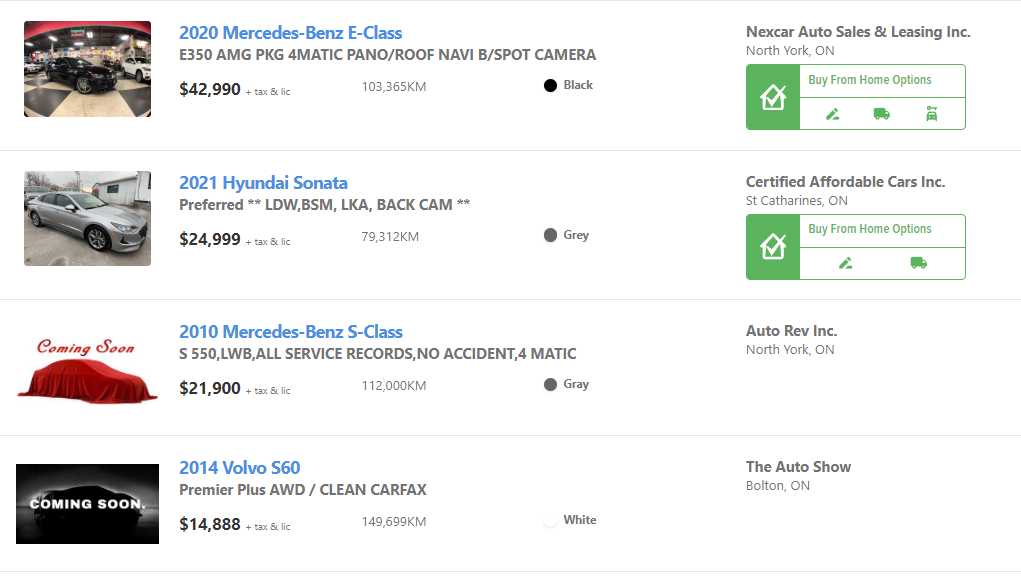

Looking at the website the listings contains the following useful data
* Title of listing
* Model of Vehicle
* Mileage (Km)
* Price (in CAD)
* Location
* Colour
* Image listing
* Dealership

Lets apply inspect element and took at how each carpage listing is organized on carpages.ca
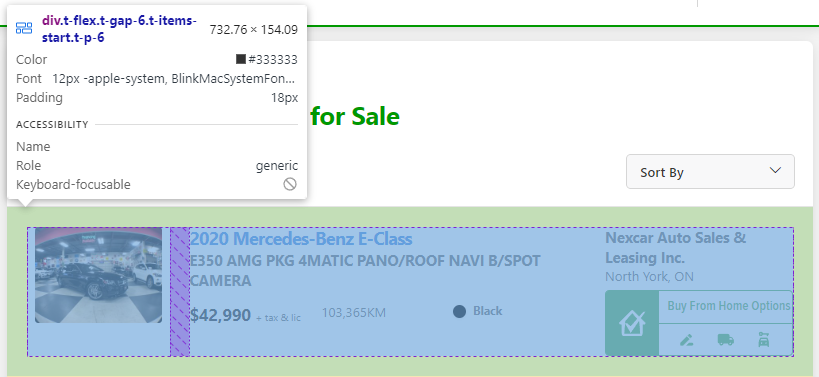

Looking at the html source code we can see that every listing is organized within a 'div' element whose class is
't-flex.t-gap-6.t-items-start.t-p-6'

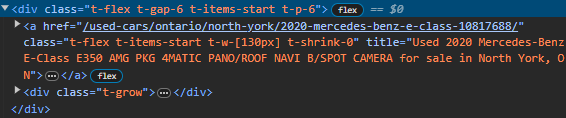

If we wish to gain additional data we need to parse through each of these html elements using Beautiful Soup

## Obtaining Data From html Tags
Lets collect all the car listings as beautiful soup elements

In [107]:
soup = BeautifulSoup(response.content,'html.parser')
cars = soup.find_all('div', class_='t-flex t-gap-6 t-items-start t-p-6')
len(cars)

50

As desired we have obtained 50 div elements, one for each of the listings. Now that we have all of the div elements for each of the listings we need to look through the html code and the data that's worth looking for.

## Relevant Data in each listing

* Titles - "Title of the listing"
* Year - Year of manufacturing for the model
* Model - Model of the vehicle
* Style - Style correpsonds to body type of the cat (ex. Sedan, SUV)
* Condition - Used or New
* Price - Price in Canadian dollars
* Mileage - Mileage in Kilometres
* Dealer - Dealership of the vehicle
* City - City in which car is located in
* Province - Canadian province the car is listed in
* Posting Link - Link for personal listing page
* Image Link - Link for posting image

Now that we know what data we're interested in we can use some html and python knowledge to obtain each of these fields

#### Getting Title, Condition, Year, Model, Make, City and Province

In [108]:
car = cars[0].findAll("a")
title = car[0].find("img").get("alt")
title

'Used 2011 Chevrolet Malibu 2LT PLATINUM, SUNROOF, LEATHER, BLUETOOTH! for sale in Orleans, ON'

Conveniently for us the title contains the condition, year,city and province.

In [109]:
# The year, model, make, city and province are located within the title and can be obtained using list and string operations
titleInfo = title.split(" ")
condition = titleInfo[0]
year = titleInfo[1]
make = titleInfo[2]
province = titleInfo[-1]
titleInfo

['Used',
 '2011',
 'Chevrolet',
 'Malibu',
 '2LT',
 'PLATINUM,',
 'SUNROOF,',
 'LEATHER,',
 'BLUETOOTH!',
 'for',
 'sale',
 'in',
 'Orleans,',
 'ON']

In [110]:
city = cars[0].findAll("p", class_="hN")[0].text.split(", ").pop(0)
city

'Orleans'

#### Getting the Model, Price, and Dealer


In [111]:
model = cars[0].findAll("a")[1].text
model

'2011 Chevrolet Malibu'

Lets obtain the price

In [112]:
price = list(filter(lambda a: a != "",str(cars[0].find("span").text).split(" ")))[-1] 
price = price[1:len(price)]
price = price.replace(",","")
price

'9991'

Lets obtain the dealer data

In [113]:
dealer = cars[0].findAll("h5")[-1].text
dealer

'Luxe Auto Lounge Inc'

#### Getting the Mileage
Will take a bit more work since we need to do some error handling, sometimes on listing sites users can put CALL

In [114]:
def getMileage(car):
    mileage = ""
    mileageInfo = car.findAll("div",class_="t-col-span-full mobile-lg:t-col-span-6 laptop:t-col-span-4")[0].find_all("span")
    for m in mileageInfo:
        mileage += m.text
    try:
        mileage = int(mileage.replace(",","")[0:-2])
    except ValueError:
        # Sometimes posters will put text in place of a mileage so we need to account for error handling using a try statement 
        pass

    return mileage
getMileage(cars[0])

141916

In [115]:
colour = cars[0].find("span",class_="t-text-sm t-font-bold").text
colour

'Black'

#### Getting posting link data and image link data

In [116]:
image_link = cars[4].find_all("a")[0].find("img").get("data-original")
#posting_link = "https://www.carpages.ca"+cars[0].find("a").get("href")
#posting_link
image_link

'https://images.carpages.ca/inventory/10837389.389862243?w=320&h=240&q=75&s=06b4a6fb3b885904aeffe08cd81c70d4'

Now lets put everything together

In [117]:
def getMileage(car):
    # Inputs:
    # car(List) - List of tags for a one car listing on carpages.ca
    #
    # Outputs:
    # mileage(int/str) - mileage as string or integer
    #
    # Purpose:
    # Gets the mileage of one car listing
    mileage = ""
    mileageInfo = car.findAll("div",class_="t-col-span-full mobile-lg:t-col-span-6 laptop:t-col-span-4")[0].find_all("span")
    for m in mileageInfo:
        mileage += m.text
    try:
        mileage = int(mileage.replace(",","")[0:-2])
    except ValueError:
        mileage = None
    return mileage

def getPrice(car):
    # Inputs:
    # car(List) - List of tags for a one car listing on carpages.ca
    #
    # Outputs:
    # price(int/str) - price as string or integer
    #
    # Purpose:
    # Gets the price of one car listing
    price = list(filter(lambda a: a != "",str(car.find("span").text).split(" ")))[-1] 
    price = price[1:len(price)]
    price = price.replace(",","")
    try:
        price = float(price)
    except ValueError:
        price = None
    return price

def ExtractPageData(bodyType,currentPage):
    # Inputs:
    # website(str) - website of carpages.ca 
    # bodyType(int) - bodyType of vehicle based off of carpages.ca's indices as defined below in bodyTypes dict
    # 
    # Outputs:
    # pageData(pd) - pandas dataframe corresponding to all of the data saved for a carpages.ca listing
    #
    # Purpose:
    # Extracts all the car data on a given webpage  
    bodyTypes = {
        1:"Convertable",
        2:"Coupe",
        3:"Hatchback",
        4:"Hybrid/Electric",
        5:"Sedan",
        6:"SUV",
        7:"Crossover",
        8:"Van/Minivan",
        9:"Pickup Truck"}

    website = "https://www.carpages.ca/used-cars/search/?num_results=50&category_id="+str(bodyType)+"&p="+str(currentPage)
    response = requests.get(website)
    status = response.status_code
    soup = BeautifulSoup(response.content,'html.parser')

    # desired fields as dictionary
    data = {
        "Titles" : [],
        "Year" : [],
        "Model" : [],
        "Make" : [],
        "Colour" : [],
        "Style" : bodyTypes[bodyType],
        "Condition" : [],
        "Price" : [],
        "Mileages" : [],
        "Dealer" : [],
        "City": [],
        "Province" : [],
        "Posting Link": [],
        "Image Link": [],
        "Source" : "carpages.ca"
    }
    soup = BeautifulSoup(response.content,'html.parser')
    cars = soup.find_all('div', class_='t-flex t-gap-6 t-items-start t-p-6')

    # loop for every car on the webpage and append the values to the data dictionary above
    for car in cars:
        vec = car.findAll("a")
        title = vec[0].find("img").get("alt")
        info = title.split(" ")
        data["Titles"].append(title)
        data["Condition"].append(info[0])
        data["Year"].append(info[1])
        data["Make"].append(info[2])
        data["Model"].append(car.find_all("a")[1].text)
        data["Province"].append(car.findAll("p", class_="hN")[0].text.split(", ").pop(1))
        data["City"].append(car.findAll("p", class_="hN")[0].text.split(", ").pop(0))
        data["Dealer"].append(car.findAll("h5")[-1].text)
        data["Mileages"].append(getMileage(car))
        data["Price"].append(getPrice(car))
        data["Posting Link"].append("https://www.carpages.ca"+car.find("a").get("href"))
        data["Image Link"].append(car.find_all("a")[0].find("img").get("data-original"))
        data["Colour"].append(car.find("span",class_="t-text-sm t-font-bold").text)

    pageData = pd.DataFrame(data)
    return pageData

def ExtractPageRangeData(bodyType,currentPage,finalPage):
    # Inputs:
    # currentPage(int) - first page you wish to extract data from
    # finalPage(int) - last page you wish to extract data from
    # bodyType(int) - bodyType of vehicle based off of carpages.ca's indices (Sedan,SUV, etc...)
    # 
    # Outputs:
    # table(pd) - pandas dataframe corresponding to all of the data saved from carpages.ca between pages currentPage->finalPage for a vehicle of a body type 
    #
    # Purpose:
    # Extracts all the car data on a given webpage  
    tableOfData = []

    while currentPage <= finalPage:
        try:
            tableOfData.append(ExtractPageData(currentPage,bodyType))
            currentPage += 1
        except Exception:
            break

    table = pd.concat(tableOfData,ignore_index=True)
    return table


Lets collect 1000 entries of data for scraping

In [118]:
table = ExtractPageRangeData(5,1,100)

#### Applying the Scraper

In [119]:
import plotly.express as px

In [65]:
table.head()

,Titles,Year,Model,Make,Colour,Style,Condition,Price,Mileages,Dealer,City,Province,Posting Link,Image Link
0,Used 2021 Hyundai Sonata Preferred+Adaptive Cr...,2021,2021 Hyundai Sonata,Hyundai,White,Sedan,Used,24999.0,87000,Sport Motors,London,ON,https://www.carpages.ca/used-cars/ontario/lond...,https://images.carpages.ca/inventory/10837317....
1,Used 2022 Toyota Corolla LE for sale in Langle...,2022,2022 Toyota Corolla,Toyota,Blue,Sedan,Used,23770.0,55300,Canadian Car and Truck Sales,Langley,BC,https://www.carpages.ca/used-cars/british-colu...,https://images.carpages.ca/inventory/10837302....
2,Used 2014 Toyota Camry LE | SUNROOF | BACKUP C...,2014,2014 Toyota Camry,Toyota,Black,Sedan,Used,13988.0,201778,GT Motor Sports Calgary,Calgary,AB,https://www.carpages.ca/used-cars/alberta/calg...,https://images.carpages.ca/inventory/10837269....
3,"Used 2020 Toyota Corolla LE-ONLY 7,192 KMS! fo...",2020,2020 Toyota Corolla,Toyota,White,Sedan,Used,25897.0,7192,Vandermeer Toyota,Cobourg,ON,https://www.carpages.ca/used-cars/ontario/cobo...,https://images.carpages.ca/inventory/10837248....
4,New 2024 Mazda MAZDA3 GS Auto i-ACTIV AWD for ...,2024,2024 Mazda MAZDA3,Mazda,Black,Sedan,New,34260.39,5,Highway Mazda,Steinbach,MB,https://www.carpages.ca/new-cars/manitoba/stei...,https://images.carpages.ca/inventory/10837233....


In [120]:
table.to_csv("datasample.csv")
# Lets save this sample for later use

## Analysis of Listing Data

##### Analysis on No. of listings by Province

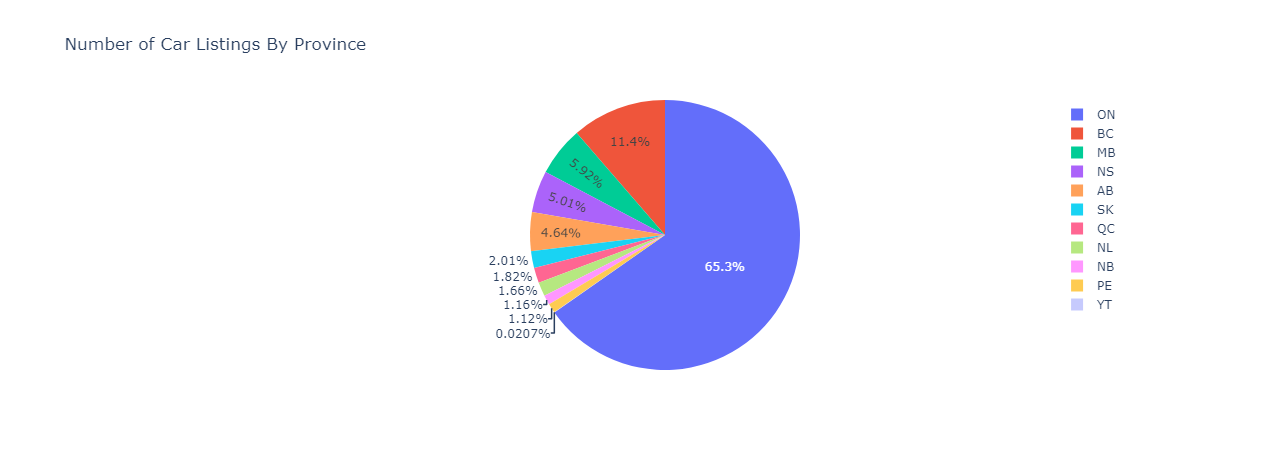

Looking at a data set of ~5000 car postings, it's no surprise that the Ontario listings make up the highest portion of listings given that it's the most populous province within the country [[1]](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901). Despite Québec being the second most populous province in the country it makes up only 1.82% of the car listings, this is no surpise as it's likely they have their own alternative websites for buying used cars like [autohebdo](https://www.autohebdo.net/). Comparison of the statscan population statistics to the current listings we can also observe that Ontario and BC are overrepresented within the 5000 listing sample, thus it would seem that carpages.ca is a popular site to use in this province.

In [ ]:
provinceCounts = table["Province"].value_counts()
fig = px.pie(provinceCounts,values="Province",names=provinceCounts.index,title="Number of Car Listings By Province")
fig.show()

#### Analysis on No. of listings by City
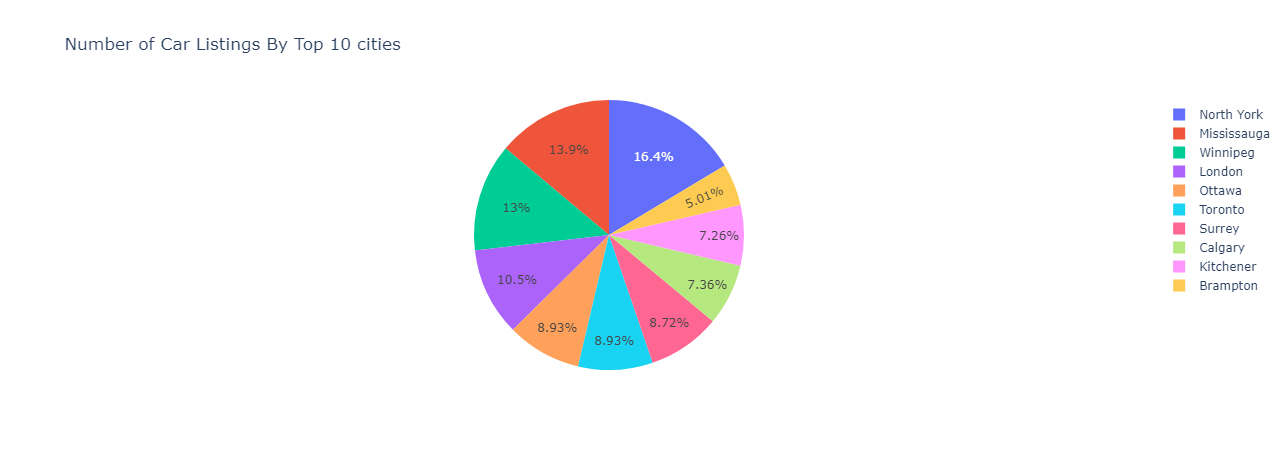
Based on the analysis of the provincial data it's no surprise that the top cities are located within Ontario. Furthermore if you're a customer in the GTA area or within 1-2hrs of the GTA it seems like you have plenty of car options on carpages.ca

In [ ]:
CityCounts = table["City"].value_counts().head(10)
fig = px.pie(CityCounts,values="City",names=CityCounts.index,title="Number of Car Listings By Top 10 cities")
fig.show()

#### Analysis on Median Price per Province

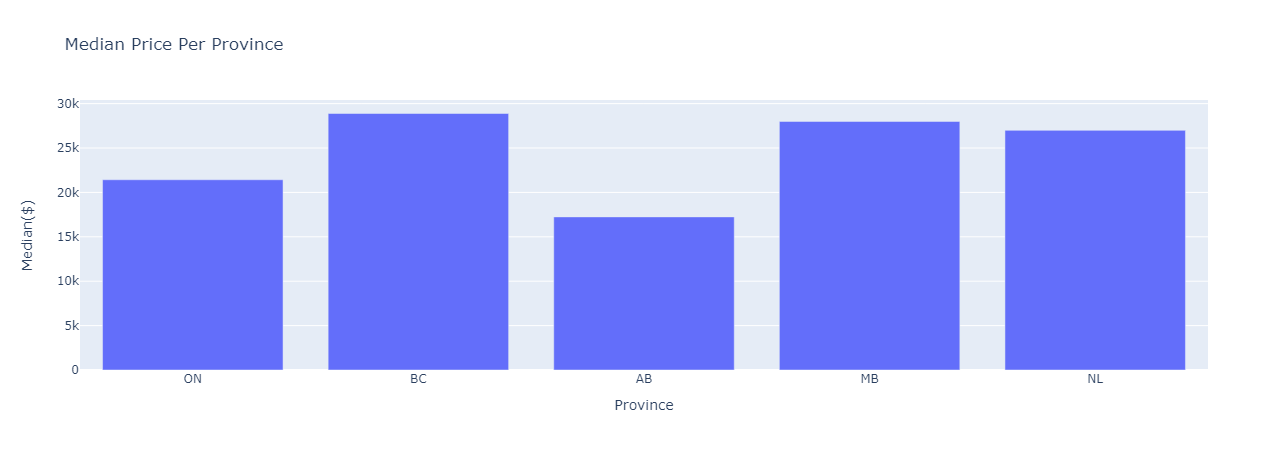

When looking at the top 5 provinces (provinces with at least 100 listings) we can see that Ontario and Alberta are the most affordable markets for sedans according to carpages.ca. On the opposite end we can see that B.C. and Manitoba have much higher median prices.

In [ ]:
provinces = table["Province"].unique()[0:5]
medians = []
for p in provinces:
    price = table.loc[table["Province"] == p,"Price"].astype(float).median()
    medians.append(price)

df = pd.DataFrame({"Province" : provinces, "Median($)" : medians})
fig = px.bar(df,x="Province",y="Median($)",title="Median Price Per Province")
fig.show()

#### Analysis on Median Price for Top 10 Cities in the Country

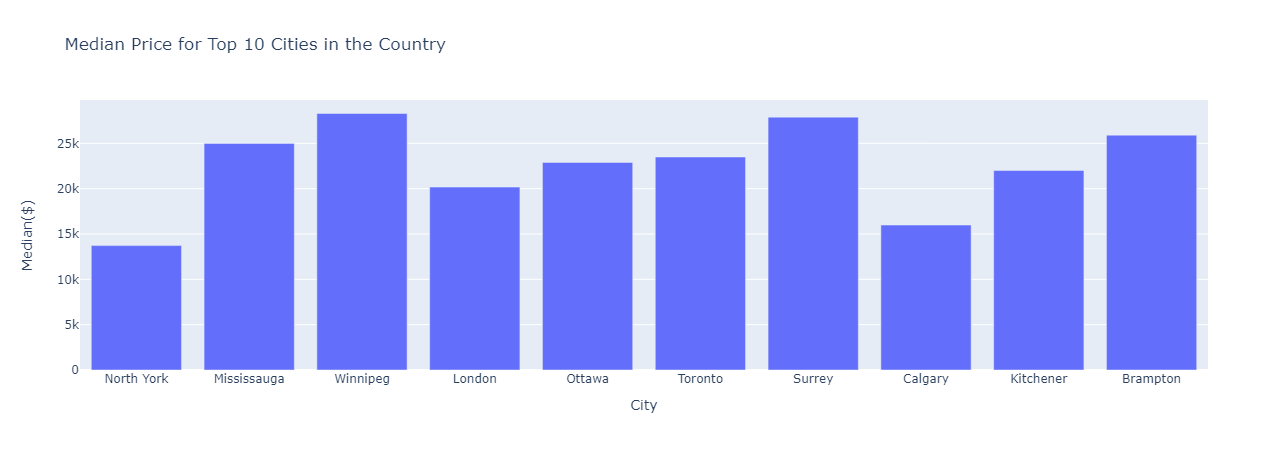

When looking at the top 10 cities we can see that North York is the most affordable option for sedans in the top 10 cities. Despite North York and Mississauga being approximately 30km away from each other the median price differences are over $10k!! Thus it might be a good idea for buyers in Missisauga to take a quick 30 minute ride to North York for savings.

In [ ]:
cities = list(table["City"].value_counts().head(10).index)
medians = []
for c in cities:
    price = table.loc[table["City"] == c,"Price"].astype(float).median()
    medians.append(price)
print(cities)
print(medians)
df = pd.DataFrame({"City" : cities, "Median($)" : medians})
fig = px.bar(df,x="City",y="Median($)",title="Median Price for Top 10 Cities in the Country")
fig.show()